<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/Binary_Image_Classification_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Challenge : Dogs-vs-Cats - Binary Image Classification using Keras
해당 포스트는 [Kaggle  Dogs-vs-Cats challenge](https://www.kaggle.com/c/dogs-vs-cats) 해결하기위해 만들었으며, 여러 가지 자료들을 참고하여 만든 포스트 입니다.


*   개발 환경 : google colab, Python3, Tensorflow, Keras
*   실험 모델 : VGG16(Transfer Learning)
*   실험에 쓰인 데이터 : Kaggle Dogs vs Cats challenge
*   Test {개: 1,000, 고양이: 1,000} (총 2,000개)
*   Training {개: 5,000, 고양이: 5,000} (총 10,000개)
*   Validation {개: 2,500, 고양이: 2,500} (총 5,000개)
*   IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

GPU 사용

In [1]:
!nvidia-smi

Wed Oct  7 08:32:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

구글 드라이브 연동 코드

In [16]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [17]:
import sys
MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states/save" #실험에 쓴 모델을 저장할 드라이브 경로
IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs" #구글 드라이브에 저장되어 있는 데이터셋(이미지)

## Kaggle  Dogs-vs-Cats challenge Dataset
Kaggle train.zip 에는 개와 고양이의 이미지 25,000 개 (고양이 색상 이미지 12,500 개 및 다양한 크기의 개 색상 이미지 12,500 개)가 포함되어 있습니다.

train Data 중 별도의 프로그램을 사용하여 고양이와 개에 개에 각각 5,000개의 훈련 이미지, 고양이와 개에 대한 2,500개의 평가 이미지, 고양이와 개에 개에 각각 1,000개의 테스트 이미지로 구성된 작은 데이터 세트를 만들었습니다. 그런 다음 이미지 Dataset.zip 파일을 Google 드라이브에 업로드했습니다.

zip 파일 cats_vs_dogs_images_small.zip은 내 Google 드라이브의 IMAGES_ZIP_DIR에서 사용할 수 있습니다. 아래 코드 셀은 로컬로 다운로드하고 /tmp 폴더에 이미지 압축을 풉니다.

In [2]:
import sys, os, random
import numpy as np
import tensorflow as tf
import keras
print('Using Tensorflow version ', tf.__version__)
print('Using keras version ', keras.__version__)
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0
Using keras version  2.4.3


In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
import os, shutil
import zipfile
 
#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'
 
print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
 
assert os.path.exists(local_zip)
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs/cats_vs_dogs_images_small.zip to /tmp/cats_vs_dogs_images_small.zip...
Extracting all images...


## 실험에 쓰일 데이터 파일 연결

In [4]:
images_root = "/tmp" # /content/drive/My Drive/img
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 224, 224, 3, 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

# Default VGG16

In [8]:
vgg_base = keras.applications.InceptionV3(include_top=True, weights='imagenet',input_shape=(299, 299, 3))
x = Dense(1, activation='sigmoid', name='predictions')(vgg_base.layers[-2].output)
vgg_base.trainable = False
model = Model(vgg_base.input,x)

model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=1,
    validation_data=eval_generator,
    validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
312/312 [==============================] - 55s 178ms/step - loss: 0.2742 - acc: 0.9085 - val_loss: 0.1227 - val_acc: 0.9736


In [12]:
def show_plots(history, plot_title=None, fig_size=None):
    """ Useful function to view plot of loss values & accuracies across the various epochs
        Works with the history object returned by the train_model(...) call """
    assert type(history) is dict

    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['acc']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    if plot_title is not None:
        plt.suptitle(plot_title)

    plt.show()
    plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals
def save_keras_model(model, base_file_name, save_dir=os.path.join('.','keras_models')):
    """ save the model structure to JSON & weights to HD5 """    
    # check if save_dir exists, else create it
    if not os.path.exists(save_dir):
        try:
            os.mkdir(save_dir)
        except OSError as err:
            print("Unable to create folder {} to save Keras model. Can't continue!".format(save_dir))
            raise err
            
    # model structure is saved to $(save_dir)/base_file_name.json
    # weights are saved to $(save_dir)/base_file_name.h5
    model_json = model.to_json()
    json_file_path = os.path.join(save_dir, (base_file_name + ".json"))
    h5_file_path = os.path.join(save_dir, (base_file_name + ".h5"))            

    with open(json_file_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5\n",
    model.save_weights(h5_file_path)
    print("Saved model to files %s and %s" % (json_file_path, h5_file_path))

def load_keras_model(base_file_name, load_dir=os.path.join('.', 'keras_models')):
    """ loads model structure & weights from previously saved state """
    # model structure is loaded $(load_dir)/base_file_name.json
    # weights are loaded from $(load_dir)/base_file_name.h5

    from tensorflow.keras.models import model_from_json

    # load model from save_path
    loaded_model = None
    json_file_path = os.path.join(load_dir, (base_file_name + ".json"))
    h5_file_path = os.path.join(load_dir, (base_file_name + ".h5"))

    if os.path.exists(json_file_path) and os.path.exists(h5_file_path):
        with open(json_file_path, "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = model_from_json(loaded_model_json)
            loaded_model.load_weights(h5_file_path)
        print("Loaded model from files %s and %s" % (json_file_path, h5_file_path))
    else:
        msg = "Model file(s) not found in %s! Expecting to find %s and %s in this directory." % (
            load_dir, (base_file_name + ".json"), (base_file_name + ".h5"))
        raise IOError(msg)
    return loaded_model

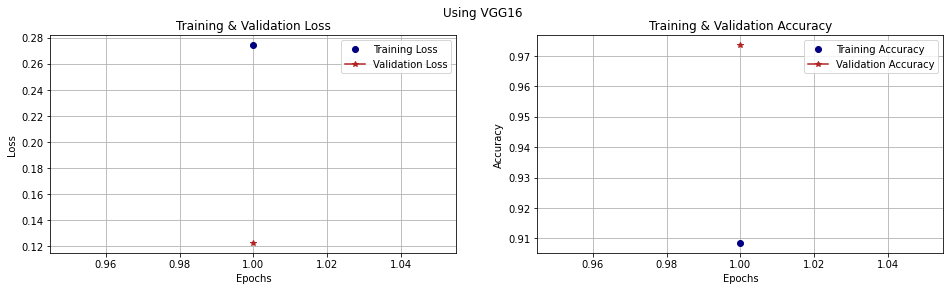

In [13]:
show_plots(hist.history, plot_title='Using VGG16')

In [14]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 36s 115ms/step - loss: 0.1132 - acc: 0.9780
Training data  -> loss: 0.113, acc: 0.978
156/156 [==============================] - 18s 115ms/step - loss: 0.1226 - acc: 0.9736
Cross-val data -> loss: 0.123, acc: 0.974
62/62 [==============================] - 7s 116ms/step - loss: 0.1083 - acc: 0.9819
Testing data   -> loss: 0.108, acc: 0.982


In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/파일명.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/파일명.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


save_keras_model(model, '파일명', MODEL_SAVE_DIR)
del vgg_base
del model

# 기본 vgg16

In [ ]:
vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
vgg_base.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(my_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
from keras.activations import softmax, relu, sigmoid
 
vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = relu
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),        
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
# for layer in model.layers:
#     if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      # layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
 
model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


kru.save_keras_model(model, 'cats_vs_dogs_vgg16', MODEL_SAVE_DIR)
del vgg_base
del model

# mse 인 vgg16

In [ ]:
from keras.activations import softmax, relu, sigmoid
 
vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = relu
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),        
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
# for layer in model.layers:
#     if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      # layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
 
model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='mse',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_mse_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_mse_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


kru.save_keras_model(model, 'cats_vs_dogs_vgg16_mse', MODEL_SAVE_DIR)
del model, vgg_base

# 활성함수가 sigmoid 이며 vgg16

In [ ]:
from keras.activations import softmax, relu, sigmoid
 
vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),        
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
 
model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_sig_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_sig_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


kru.save_keras_model(model, 'cats_vs_dogs_vgg16_sig', MODEL_SAVE_DIR)
del model, vgg_base

# 활성함수가 sigmoid이며 mse 인 vgg16

In [ ]:
from keras.activations import softmax, relu, sigmoid
 
vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),        
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
 
model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='mse',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_sig_mse_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/cats_vs_dogs_vgg16_sig_mse_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


kru.save_keras_model(model, 'cats_vs_dogs_vgg16_sig_mse', MODEL_SAVE_DIR)
del model, vgg_base

# test

In [ ]:
# cats_vs_dogs_vgg16
# cats_vs_dogs_vgg16_mse
# cats_vs_dogs_vgg16_sig
# cats_vs_dogs_vgg16_sig_mse
model = kru.load_keras_model('cats_vs_dogs_vgg16',MODEL_SAVE_DIR)
print(model.summary())

In [ ]:
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

In [ ]:
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm
predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)
 
for test_image in tqdm(test_image_files):
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0
 
    images_list = np.vstack([x])
    classes = model_xfer.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))